In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
from  datetime import datetime, timedelta
import gc
import numpy as np, pandas as pd
import lightgbm as lgb
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
from scripts import m5_common

pd.options.display.max_columns = 50

### Path

In [3]:
path = Path('/kaggle/m5_forecasting/')
assert(path.exists())

In [4]:
h = 28 
tr_last = 1913
fday = datetime(2016, 4, 25) 
fday

datetime.datetime(2016, 4, 25, 0, 0)

In [5]:
%%time

prices, cal = m5_common.prepare_tables(path)

CPU times: user 1.44 s, sys: 132 ms, total: 1.57 s
Wall time: 1.57 s


In [6]:
weather_df = pd.read_csv(path/'weather/weather_2010_2020.csv')
weather_df["date"] = pd.to_datetime(weather_df["Date"])
del weather_df["Date"]
del weather_df["Anomaly"]
weather_df['Value'] = weather_df['Value'].astype('float16')
weather_df.columns = ['temperature',  'date']

In [7]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3257 entries, 0 to 3256
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   temperature  3257 non-null   float16       
 1   date         3257 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float16(1)
memory usage: 31.9 KB


In [8]:
# %%time

# cal = cal.merge(weather_df, on=['date'], copy = False)

In [9]:
event_name_1_map, event_type_1_map = m5_common.replace_cal_cols(cal)

In [10]:
cal[(cal.date > '2012-01-01') & (cal.date < '2012-01-05')]

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
338,2012-01-02,11149,1,3,1,2012,d_339,0,0,0,0,1.0,0.0,1.0
339,2012-01-03,11149,5,4,1,2012,d_340,0,0,0,0,1.0,1.0,1.0
340,2012-01-04,11149,6,5,1,2012,d_341,0,0,0,0,1.0,0.0,0.0


In [11]:
uint8_types= ['event_name_1', 'event_type_1', 'event_name_2', 'event_type_2', 'month', 'wday', 'weekday', 
              'snap_CA', 'snap_TX', 'snap_WI']
m5_common.convert_uint8(cal, uint8_types)

In [15]:
day_of_year = 'Dayofyear'

def prepare_day_of_year(df):
    df[day_of_year] = getattr(df['date'].dt, day_of_year.lower()).astype('uint16')

In [16]:
def add_days_before(dt, day=25, month=12, col_name='before_christmas'):
    diff_list = []
    for d in dt['date']:
        target = datetime(d.year, month, day)
        diff = (target - d.to_pydatetime()).days
        if(diff < 0):
            christmas = datetime(d.year + 1, month, day)
            diff = (christmas - d.to_pydatetime()).days
            if diff < 0:
                print('target', target, d, diff)
        diff_list.append(diff)
    dt[col_name] = diff_list
    dt[col_name] = dt[col_name].astype('uint16')

In [17]:
add_days_before(cal)
# add_days_before(cal, day=31, month=10, col_name='before_halloween')
# add_days_before(cal, day=4, month=7, col_name='before_independence_day')

In [20]:
easter_western = {2011: datetime(2011, 4, 24), 2012: datetime(2012, 4, 8), 2013: datetime(2013, 3, 31)
 , 2014: datetime(2014, 4, 20), 2015: datetime(2015, 4, 5), 2016: datetime(2016, 4, 27), 2017: datetime(2017, 4, 16)}

def add_days_before_special_date(dt, date_dict=easter_western, col_name='before_easter'):
    diff_list = []
    for d in cal['date']:
        year = d.year
        target = date_dict[year]
        diff = (target - d.to_pydatetime()).days
        if(diff < 0):
            target = date_dict[year + 1]
            diff = (target - d.to_pydatetime()).days
        diff_list.append(diff)
    dt[col_name] = diff_list
    dt[col_name] = dt[col_name].astype('uint16')

In [21]:
# add_days_before_special_date(cal)

In [22]:
cal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1969 entries, 0 to 1968
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   date                     1969 non-null   datetime64[ns]
 1   wm_yr_wk                 1969 non-null   int16         
 2   weekday                  1969 non-null   uint8         
 3   wday                     1969 non-null   uint8         
 4   month                    1969 non-null   uint8         
 5   year                     1969 non-null   int16         
 6   d                        1969 non-null   object        
 7   event_name_1             1969 non-null   uint8         
 8   event_type_1             1969 non-null   uint8         
 9   event_name_2             1969 non-null   uint8         
 10  event_type_2             1969 non-null   uint8         
 11  snap_CA                  1969 non-null   uint8         
 12  snap_TX                  1969 non-

In [23]:
cal

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,before_christmas,before_halloween,before_independence_day
0,2011-01-29,11101,2,1,1,2011,d_1,0,0,0,0,0,0,0,330,275,156
1,2011-01-30,11101,3,2,1,2011,d_2,0,0,0,0,0,0,0,329,274,155
2,2011-01-31,11101,1,3,1,2011,d_3,0,0,0,0,0,0,0,328,273,154
3,2011-02-01,11101,5,4,2,2011,d_4,0,0,0,0,1,1,0,327,272,153
4,2011-02-02,11101,6,5,2,2011,d_5,0,0,0,0,1,0,1,326,271,152
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1964,2016-06-15,11620,6,5,6,2016,d_1965,0,0,0,0,0,1,1,193,138,19
1965,2016-06-16,11620,4,6,6,2016,d_1966,0,0,0,0,0,0,0,192,137,18
1966,2016-06-17,11620,0,7,6,2016,d_1967,0,0,0,0,0,0,0,191,136,17
1967,2016-06-18,11621,2,1,6,2016,d_1968,0,0,0,0,0,0,0,190,135,16


In [26]:
FIRST_DAY = 1 # If you want to load all the data set it to '1' -->  Great  memory overflow  risk !

In [27]:
%%time

df = m5_common.create_dt(cal, prices, is_train=True, first_day= FIRST_DAY, tr_last=tr_last, path=path)

CPU times: user 42.3 s, sys: 5.83 s, total: 48.1 s
Wall time: 48.1 s


In [28]:
def replace_cat(dt, field, target_type='uint8'):
    uniques = dt[field].unique()
    uniques.sort()
    print(uniques)
    mapping = {e: i for i, e in enumerate(uniques)}
    print(mapping)
    dt.replace({field: mapping}, inplace=True)
    dt[field] = dt[field].astype(target_type)

def replace_cats(dt):
    replace_cat(dt, 'wday')
    replace_cat(dt, 'month')
    replace_cat(dt, 'year')
    replace_cat(dt, 'mday')

In [29]:
replace_cats(df)

# replace_cat(df, 'Dayofyear', 'uint16')
# replace_cat(df, 'week')

[1 2 3 4 5 6 7]
{1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6}
[ 1  2  3  4  5  6  7  8  9 10 11 12]
{1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6, 8: 7, 9: 8, 10: 9, 11: 10, 12: 11}
[2011 2012 2013 2014 2015 2016]
{2011: 0, 2012: 1, 2013: 2, 2014: 3, 2015: 4, 2016: 5}
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31]
{1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6, 8: 7, 9: 8, 10: 9, 11: 10, 12: 11, 13: 12, 14: 13, 15: 14, 16: 15, 17: 16, 18: 17, 19: 18, 20: 19, 21: 20, 22: 21, 23: 22, 24: 23, 25: 24, 26: 25, 27: 26, 28: 27, 29: 28, 30: 29, 31: 30}


In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46027957 entries, 4081 to 46025082
Data columns (total 29 columns):
 #   Column                   Dtype         
---  ------                   -----         
 0   id                       object        
 1   item_id                  int16         
 2   dept_id                  int16         
 3   store_id                 int16         
 4   cat_id                   int16         
 5   state_id                 int16         
 6   d                        object        
 7   sales                    float16       
 8   date                     datetime64[ns]
 9   wm_yr_wk                 int16         
 10  weekday                  uint8         
 11  wday                     uint8         
 12  month                    uint8         
 13  year                     uint8         
 14  event_name_1             uint8         
 15  event_type_1             uint8         
 16  event_name_2             uint8         
 17  event_type_2          

In [31]:
# Fraction of zeros
df[df['sales'] == 0.].shape[0] / df.shape[0]

0.6115931671701179

In [32]:
df

,id,item_id,dept_id,store_id,cat_id,state_id,d,sales,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,before_christmas,before_halloween,before_independence_day,sell_price,Dayofyear,week,mday,lag_price_1
4081,FOODS_1_001_CA_1_evaluation,1536,4,0,2,0,d_1,3.0,2011-01-29,11101,2,0,0,0,0,0,0,0,0,0,0,330,275,156,5.269531,29,4,28,NaN
4082,FOODS_1_001_CA_1_evaluation,1536,4,0,2,0,d_2,0.0,2011-01-30,11101,3,1,0,0,0,0,0,0,0,0,0,329,274,155,5.269531,30,4,29,5.269531
4083,FOODS_1_001_CA_1_evaluation,1536,4,0,2,0,d_3,0.0,2011-01-31,11101,1,2,0,0,0,0,0,0,0,0,0,328,273,154,5.269531,31,5,30,5.269531
4084,FOODS_1_001_CA_1_evaluation,1536,4,0,2,0,d_4,1.0,2011-02-01,11101,5,3,1,0,0,0,0,0,1,1,0,327,272,153,5.269531,32,5,0,5.269531
4085,FOODS_1_001_CA_1_evaluation,1536,4,0,2,0,d_5,4.0,2011-02-02,11101,6,4,1,0,0,0,0,0,1,0,1,326,271,152,5.269531,33,5,1,5.269531
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45956915,HOUSEHOLD_2_516_WI_3_evaluation,2047,3,9,1,2,d_1909,0.0,2016-04-20,11612,6,4,3,5,0,0,0,0,0,0,0,249,194,75,1.000000,111,16,19,1.000000
45956916,HOUSEHOLD_2_516_WI_3_evaluation,2047,3,9,1,2,d_1910,0.0,2016-04-21,11612,4,5,3,5,0,0,0,0,0,0,0,248,193,74,1.000000,112,16,20,1.000000
45956917,HOUSEHOLD_2_516_WI_3_evaluation,2047,3,9,1,2,d_1911,0.0,2016-04-22,11612,0,6,3,5,0,0,0,0,0,0,0,247,192,73,1.000000,113,16,21,1.000000
46025081,HOUSEHOLD_2_516_WI_3_evaluation,2047,3,9,1,2,d_1912,0.0,2016-04-23,11613,2,0,3,5,0,0,0,0,0,0,0,246,191,72,1.000000,114,16,22,1.000000


In [34]:
%%time

m5_common.create_fea(df)

CPU times: user 1min 34s, sys: 7.7 s, total: 1min 42s
Wall time: 1min 42s


In [35]:
df.dropna(inplace = True)
df.shape

(45174237, 39)

In [36]:
df.tail()

,id,item_id,dept_id,store_id,cat_id,state_id,d,sales,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,before_christmas,before_halloween,before_independence_day,sell_price,Dayofyear,week,mday,lag_price_1,emean_7_7,esmean_7_7,emean_7_28,esmean_7_28,emean_28_7,esmean_28_7,emean_28_28,esmean_28_28,lag_1,lag_2
45956915,HOUSEHOLD_2_516_WI_3_evaluation,2047,3,9,1,2,d_1909,0.0,2016-04-20,11612,6,4,3,5,0,0,0,0,0,0,0,249,194,75,1.0,111,16,19,1.0,0.000059,0.002300,0.024963,0.058594,0.017822,0.038788,0.079956,0.083252,0.0,0.0
45956916,HOUSEHOLD_2_516_WI_3_evaluation,2047,3,9,1,2,d_1910,0.0,2016-04-21,11612,4,5,3,5,0,0,0,0,0,0,0,248,193,74,1.0,112,16,20,1.0,0.000045,0.001972,0.018723,0.050201,0.016602,0.037384,0.074463,0.080261,0.0,0.0
45956917,HOUSEHOLD_2_516_WI_3_evaluation,2047,3,9,1,2,d_1911,0.0,2016-04-22,11612,0,6,3,5,0,0,0,0,0,0,0,247,192,73,1.0,113,16,21,1.0,0.000033,0.001690,0.014038,0.043030,0.015457,0.036041,0.069336,0.077393,0.0,0.0
46025081,HOUSEHOLD_2_516_WI_3_evaluation,2047,3,9,1,2,d_1912,0.0,2016-04-23,11613,2,0,3,5,0,0,0,0,0,0,0,246,191,72,1.0,114,16,22,1.0,0.000025,0.001449,0.010529,0.036896,0.014389,0.034760,0.064514,0.074646,0.0,0.0
46025082,HOUSEHOLD_2_516_WI_3_evaluation,2047,3,9,1,2,d_1913,0.0,2016-04-24,11613,3,1,3,5,0,0,0,0,0,0,0,245,190,71,1.0,115,16,23,1.0,0.000019,0.001242,0.007896,0.031616,0.013397,0.033539,0.060089,0.071960,0.0,0.0


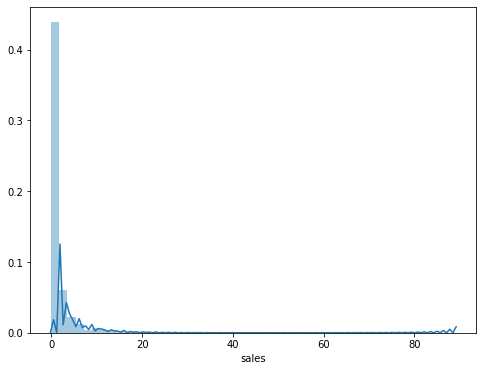

In [37]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.distplot(df['sales'][:200000])

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45174237 entries, 342559 to 46025082
Data columns (total 39 columns):
 #   Column                   Dtype         
---  ------                   -----         
 0   id                       object        
 1   item_id                  int16         
 2   dept_id                  int16         
 3   store_id                 int16         
 4   cat_id                   int16         
 5   state_id                 int16         
 6   d                        object        
 7   sales                    float16       
 8   date                     datetime64[ns]
 9   wm_yr_wk                 int16         
 10  weekday                  uint8         
 11  wday                     uint8         
 12  month                    uint8         
 13  year                     uint8         
 14  event_name_1             uint8         
 15  event_type_1             uint8         
 16  event_name_2             uint8         
 17  event_type_2        

In [ ]:
selected_features = ['id', 'item_id', 'dept_id', 'store_id', 'cat_id', 'state_id', 'd', 'sales', 'date', 'wm_yr_wk', 'weekday', 'wday', 'month', 'year', 
                     'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2', 'snap_CA', 'snap_TX', 'snap_WI', 'before_christmas', 'sell_price', 'Dayofyear', 'week', 
                     'mday', 'emean_7_1', 'esmean_7_1', 'emean_7_7', 'esmean_7_28', 'emean_28_1', 'esmean_28_1', 'emean_28_7', 'esmean_28_7', 'emean_28_28', 'esmean_28_28', 'lag_1', 'lag_2']
m5_common.remove_features(df, selected_features)

In [39]:
cat_feats = ['item_id', 'dept_id','store_id', 'cat_id', 'state_id', 
             "event_name_1", "event_name_2", "event_type_1", "event_type_2", 'snap_CA', 'snap_TX', 'snap_WI']
useless_cols = ["id", "date", "sales","d", "wm_yr_wk", "weekday", "revenue"]
train_cols = df.columns[~df.columns.isin(useless_cols)]
X_train = df[train_cols]
y_train = df["sales"]

np.random.seed(777)

size_valid_set = 2_000_000
fake_valid_inds = np.random.choice(X_train.index.values, size_valid_set, replace = False)
train_inds = np.setdiff1d(X_train.index.values, fake_valid_inds)

In [40]:
X = X_train.loc[train_inds]
y = y_train.loc[train_inds]

X_valid = X_train.loc[fake_valid_inds]
y_valid = y_train.loc[fake_valid_inds]

In [41]:
del df
gc.collect()

49

In [42]:
if not 'n_estimators' in locals():
    n_estimators = 2000
    
if not 'tweedie_variance_power' in locals():
    tweedie_variance_power = 1.28
    
if not 'sub_row' in locals():
    sub_row = 0.75
    
if not 'bagging_freq' in locals():
    bagging_freq = 1
    
if not 'learning_rate' in locals():
    learning_rate = 0.075

leave_size = 10
params = {
        'boosting_type': 'gbdt',
        "objective" : "tweedie",
        'tweedie_variance_power': tweedie_variance_power,
        "metric" :"rmse",
        "force_row_wise" : True,
        "learning_rate" : learning_rate,
#         "sub_feature" : 0.8,
        "sub_row" : sub_row,
        "bagging_freq" : bagging_freq,
#         "lambda_l1" : 0.2,
        "lambda_l2" : 0.1,
        "nthread" : 10,
        "metric": ["rmse"],
        'verbosity': 20,
        'num_leaves': 2**leave_size-1,
        "min_data_in_leaf": 2**(leave_size + 1)-1,
        "n_estimators": n_estimators
}

In [44]:
m_lgb_regressor = lgb.LGBMRegressor(**params)

In [45]:
%%time

m_lgb_regressor.fit(X=X, y=y, 
          eval_set=[(X, y), (X_valid, y_valid)],
          eval_names=['train sales', 'valid sales'], 
          eval_metric=params['metric'],
          verbose=params['verbosity'],
          early_stopping_rounds=100,
          categorical_feature=cat_feats)

/opt/anaconda3/envs/deeplearning/lib/python3.7/site-packages/lightgbm/basic.py:1247: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['cat_id', 'dept_id', 'event_name_1', 'event_name_2', 'event_type_1', 'event_type_2', 'item_id', 'snap_CA', 'snap_TX', 'snap_WI', 'state_id', 'store_id']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 100 rounds
[20]	train sales's rmse: 2.77759	valid sales's rmse: 2.70389
[40]	train sales's rmse: 2.30273	valid sales's rmse: 2.23902
[60]	train sales's rmse: 2.23992	valid sales's rmse: 2.18501
[80]	train sales's rmse: 2.2087	valid sales's rmse: 2.1644
[100]	train sales's rmse: 2.18876	valid sales's rmse: 2.15375
[120]	train sales's rmse: 2.17546	valid sales's rmse: 2.14705
[140]	train sales's rmse: 2.16592	valid sales's rmse: 2.14228
[160]	train sales's rmse: 2.15944	valid sales's rmse: 2.13898
[180]	train sales's rmse: 2.15162	valid sales's rmse: 2.13569
[200]	train sales's rmse: 2.14533	valid sales's rmse: 2.13304
[220]	train sales's rmse: 2.14003	valid sales's rmse: 2.13129
[240]	train sales's rmse: 2.1343	valid sales's rmse: 2.12882
[260]	train sales's rmse: 2.12879	valid sales's rmse: 2.12723
[280]	train sales's rmse: 2.12389	valid sales's rmse: 2.1259
[300]	train sales's rmse: 2.11893	valid sales's rmse: 2.12443
[320]	train sale

LGBMRegressor(bagging_freq=1, boosting_type='gbdt', class_weight=None,
              colsample_bytree=1.0, force_row_wise=True,
              importance_type='split', lambda_l2=0.1, learning_rate=0.075,
              max_depth=-1, metric=['rmse'], min_child_samples=20,
              min_child_weight=0.001, min_data_in_leaf=2047, min_split_gain=0.0,
              n_estimators=1400, n_jobs=-1, nthread=10, num_leaves=1023,
              objective='tweedie', random_state=None, reg_alpha=0.0,
              reg_lambda=0.0, silent=True, sub_row=0.75, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0,
              tweedie_variance_power=1.25, verbosity=20)

In [46]:
class Importance():
    
    def __init__(self, model, eval_metric):
        self.model, self.eval_metric = model, eval_metric
        self.feature_importances = pd.DataFrame(list(zip(X_train.columns, model.feature_importances_)),
                                           columns=['feature', 'importance'])

    def plot_feature_importance(self, drop_null_importance: bool = True, top_n: int = 10):
        """
        Plot default feature importance.

        :param drop_null_importance: drop columns with null feature importance
        :param top_n: show top n columns
        :return:
        """

        top_feats = self.get_top_features(drop_null_importance, top_n)
        feature_importances = self.feature_importances.loc[self.feature_importances['feature'].isin(top_feats)]
        feature_importances['feature'] = feature_importances['feature'].astype(str)
        top_feats = [str(i) for i in top_feats]
        a4_dims = (11.7, 8.27)
        fig, ax = plt.subplots(figsize=a4_dims)
        sns.barplot(data=feature_importances, x='importance', y='feature', orient='h', order=top_feats, ax=ax)
        plt.title('Feature importances')

    def get_top_features(self, drop_null_importance: bool = True, top_n: int = 10):
        """
        Get top features by importance.

        :param drop_null_importance:
        :param top_n:
        :return:
        """
        grouped_feats = self.feature_importances.groupby(['feature'])['importance'].mean()
        if drop_null_importance:
            grouped_feats = grouped_feats[grouped_feats != 0]
        return list(grouped_feats.sort_values(ascending=False).index)[:top_n]
    
    def plot_metric(self):
        """
        Plot training progress.
        Inspired by `plot_metric` from https://lightgbm.readthedocs.io/en/latest/_modules/lightgbm/plotting.html

        :return:
        """
        full_evals_results = pd.DataFrame()
        for model in [self.model]:
            evals_result = pd.DataFrame()
            for k in model.evals_result_.keys():
                evals_result[k] = model.evals_result_[k][self.eval_metric]
            evals_result = evals_result.reset_index().rename(columns={'index': 'iteration'})
            full_evals_results = full_evals_results.append(evals_result)

        full_evals_results = full_evals_results.melt(id_vars=['iteration']).rename(columns={'value': self.eval_metric,
                                                                                            'variable': 'dataset'})
        sns.lineplot(data=full_evals_results, x='iteration', y=self.eval_metric, hue='dataset')
#         categorical_feature  plt.title('Training progress')

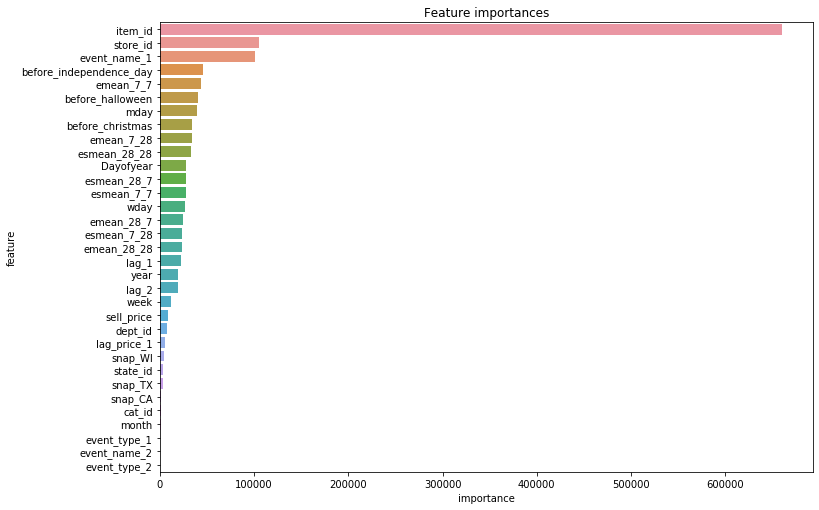

In [47]:
importance = Importance(m_lgb_regressor, 'rmse')
importance.plot_feature_importance(top_n=40)

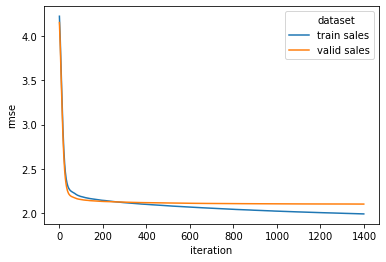

In [48]:
importance.plot_metric()

In [49]:
for iter in [None, 800, 1000, 1200]:
    m_lgb_regressor.booster_.save_model(str(path/f"m5_model_{'best' if iter is None else iter}.lgb"), num_iteration=iter)

In [50]:
m_lgb = lgb.Booster(model_file=str(path/"m5_model_best.lgb"))

In [51]:
!du -h {path/"m5_model*.lgb"}

109M	/kaggle/m5_forecasting/m5_model.lgb
17M	/kaggle/m5_forecasting/m5_model_0.lgb
17M	/kaggle/m5_forecasting/m5_model_1.lgb
240M	/kaggle/m5_forecasting/m5_model_1000.lgb
280M	/kaggle/m5_forecasting/m5_model_1200.lgb
17M	/kaggle/m5_forecasting/m5_model_2.lgb
17M	/kaggle/m5_forecasting/m5_model_3.lgb
17M	/kaggle/m5_forecasting/m5_model_4.lgb
198M	/kaggle/m5_forecasting/m5_model_800.lgb
320M	/kaggle/m5_forecasting/m5_model_best.lgb
364M	/kaggle/m5_forecasting/m5_model_binary.lgb
50M	/kaggle/m5_forecasting/m5_model_tweedie_1.2_800.lgb


In [52]:
from tqdm.notebook import tqdm

In [ ]:
%%time

max_lags = h * 2 + 1
sub = 0.
cols = [f"F{i}" for i in range(1,29)]
te = m5_common.create_dt(cal, prices, False, first_day=FIRST_DAY, path=path)
replace_cats(te)

for tdelta in tqdm(range(0, h), total=h):
    day = fday + timedelta(days=tdelta)
    print(tdelta, day)
    tst = te[(te.date >= day - timedelta(days=max_lags)) & (te.date <= day)].copy()
    m5_common.create_fea(tst, False)
    tst = tst.loc[tst.date == day, train_cols]
    te.loc[te.date == day, "sales"] = m_lgb.predict(tst)

[1 2 3 4 5 6 7]
{1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6}
[ 1  2  3  4  5  6  7  8  9 10 11 12]
{1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6, 8: 7, 9: 8, 10: 9, 11: 10, 12: 11}
[2011 2012 2013 2014 2015 2016]
{2011: 0, 2012: 1, 2013: 2, 2014: 3, 2015: 4, 2016: 5}
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31]
{1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6, 8: 7, 9: 8, 10: 9, 11: 10, 12: 11, 13: 12, 14: 13, 15: 14, 16: 15, 17: 16, 18: 17, 19: 18, 20: 19, 21: 20, 22: 21, 23: 22, 24: 23, 25: 24, 26: 25, 27: 26, 28: 27, 29: 28, 30: 29, 31: 30}


0 2016-04-25 00:00:00
1 2016-04-26 00:00:00
2 2016-04-27 00:00:00
3 2016-04-28 00:00:00
4 2016-04-29 00:00:00
5 2016-04-30 00:00:00
6 2016-05-01 00:00:00
7 2016-05-02 00:00:00
8 2016-05-03 00:00:00
9 2016-05-04 00:00:00
10 2016-05-05 00:00:00
11 2016-05-06 00:00:00


In [ ]:
te_sub = te.loc[te.date >= fday, ["id", "sales"]].copy()
te_sub["id"] = te_sub["id"].str.replace("evaluation$", "validation")
te_sub["F"] = [f"F{rank}" for rank in te_sub.groupby("id")["id"].cumcount()+1]
te_sub = te_sub.set_index(["id", "F" ]).unstack()["sales"][cols].reset_index()
te_sub.fillna(0., inplace = True)
te_sub.sort_values("id", inplace = True)
te_sub.reset_index(drop=True, inplace = True)
sub = te_sub

In [ ]:
%time

sub2 = sub.copy()
sub2["id"] = sub2["id"].str.replace("validation$", "evaluation")
sub = pd.concat([sub, sub2], axis=0, sort=False)
sub.to_csv("submission.csv",index=False)

In [ ]:
check = pd.read_csv('submission.csv')
check[(check['id'] == 'FOODS_1_001_CA_1_validation') | (check['id'] == 'FOODS_1_001_CA_1_evaluation')]

In [ ]:
check